# Minerals Classification

### Import all the Dependencies

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

### Set all the Constants

In [10]:
BATCH_SIZE = 25
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Minet 5640 Images",
    seed= 123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5624 files belonging to 7 classes.


### Removing all corrupt images

In [1]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'C:\Users\PC\Documents\Data Science\mineral-classification\training\Minet 5640 Images'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

C:\Users\PC\AppData\Local\Temp\ipykernel_17924\1187201229.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


processing class directory  biotite
processing class directory  bornite
processing class directory  chrysocolla
processing class directory  malachite
processing class directory  muscovite
processing class directory  pyrite
processing class directory  quartz
 no improper image files were found


In [7]:
class_names = dataset.class_names
class_names

['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

In [23]:
i = 0
for image_batch, labels_batch in dataset.take(1): # dataset.take(n) Takes the "n" batch of images, in this case 1
    #i = 1+i
    #print(i)
    print(image_batch.shape)
    print(labels_batch.numpy())

(25, 224, 224, 3)
[6 0 5 5 5 0 0 6 2 2 0 2 3 5 3 2 3 6 3 5 5 0 0 6 3]


As you can see above, each element in the dataset is a tuple. First element is a batch of 25 elements of images. Second element is a batch of 25 elements of class labels 

### Visualize some of the minerals

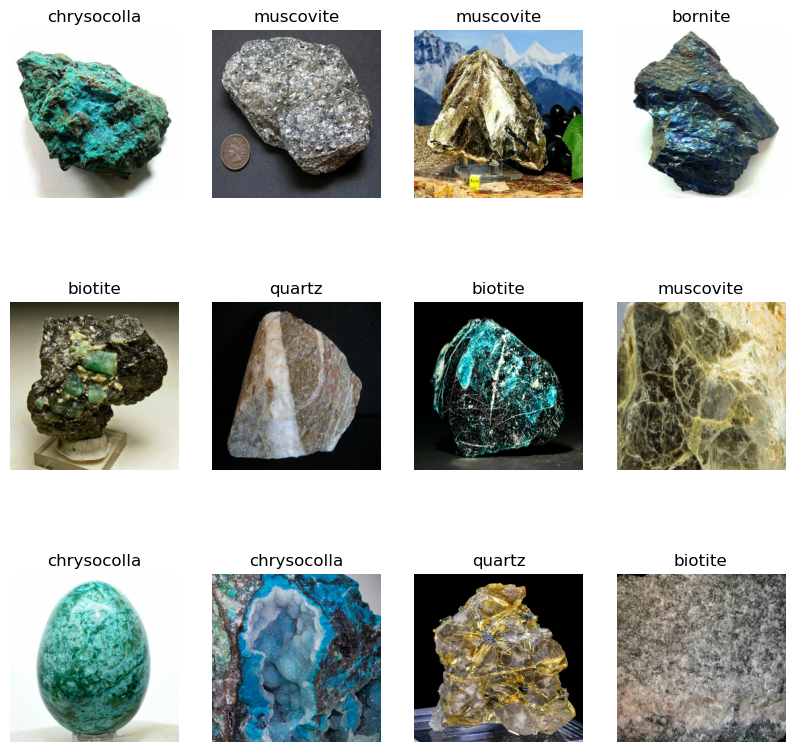

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

225

In [9]:
train_size = 0.8
len(dataset)*train_size

180.0

In [10]:
train_ds = dataset.take(180)
len(train_ds)

180

In [11]:
test_ds = dataset.skip(180)
len(test_ds)

45

In [12]:
val_size=0.1
len(dataset)*val_size

22.5

In [13]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [14]:
test_ds = test_ds.skip(22)
len(test_ds)

23

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

180

In [19]:
len(val_ds)

22

In [20]:
len(test_ds)

23

### Cache, Shuffle, and Prefetch the Dataset

Cache: caching refers to storing and retrieving data in a high-speed, temporary storage location; is commonly employed to store preprocessed or augmented data, model parameters, or intermediate results. It helps improve training efficiency by reducing the need to repeatedly load and process the same data during multiple epochs

Shuffle: shuffling involves randomly reordering the training data samples therefore is crucial for preventing the model from memorizing the order of training examples, which could lead to overfitting. It ensures that the model generalizes well to unseen data by presenting a diverse set of samples in each epoch.

Prefetch:  Prefetching is a technique used to overlap the data loading and model training processes. It involves fetching the next batch of data while the current batch is being processed, reducing the idle time of the GPU or CPU, so, optimizes resource utilization by minimizing the time the model spends waiting for data

In [61]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 255).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [62]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data augmentation involves applying random transformations to the input data, such as rotation, scaling, flipping, or cropping, to artificially increase the diversity of the training set. This helps the model generalize better to variations in the input data. By exposing the model to a more extensive range of augmented data, it becomes more robust and performs better on unseen examples.

In [63]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [64]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use the pretrained model MobileNet v2. coupled with a ReLU layer and a Softmax activation in the output layer. We also add the initial layers for resizing, normalization.

In [ ]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(128, 128, 3), trainable=False) # False so i keep the values of the weights intact.

In [66]:
n_classes = 7

model = tf.keras.Sequential([
  resize_and_rescale,
  pretrained_model_without_top_layer,
  layers.Dense(64, activation='relu'),  
  layers.Dense(n_classes, activation='softmax')
])

model.build([25, 128, 128, 3])  # Batch input shape.

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (25, 128, 128, 3)         0         
                                                                 
 keras_layer_2 (KerasLayer)  (25, 1001)                1692489   
                                                                 
 dense_8 (Dense)             (25, 64)                  64128     
                                                                 
 dense_9 (Dense)             (25, 7)                   455       
                                                                 
Total params: 1757072 (6.70 MB)
Trainable params: 64583 (252.28 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [67]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [68]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
180/180 [==============================] - 111s 338ms/step - loss: 1.1898 - accuracy: 0.5875 - val_loss: 0.9041 - val_accuracy: 0.6927
Epoch 2/50
180/180 [==============================] - 20s 108ms/step - loss: 0.7945 - accuracy: 0.7202 - val_loss: 0.7661 - val_accuracy: 0.7073
Epoch 3/50
180/180 [==============================] - 19s 107ms/step - loss: 0.6605 - accuracy: 0.7679 - val_loss: 0.6519 - val_accuracy: 0.7709
Epoch 4/50
180/180 [==============================] - 19s 106ms/step - loss: 0.5699 - accuracy: 0.7975 - val_loss: 0.7746 - val_accuracy: 0.7400
Epoch 5/50
180/180 [==============================] - 19s 108ms/step - loss: 0.5020 - accuracy: 0.8266 - val_loss: 0.5961 - val_accuracy: 0.7982
Epoch 6/50
180/180 [==============================] - 20s 109ms/step - loss: 0.4492 - accuracy: 0.8429 - val_loss: 0.6040 - val_accuracy: 0.7782
Epoch 7/50
180/180 [==============================] - 20s 108ms/step - loss: 0.4361 - accuracy: 0.8526 - val_loss: 0.5913 - val_a

In [69]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 40s 75ms/step - loss: 0.7294 - accuracy: 0.8087


Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

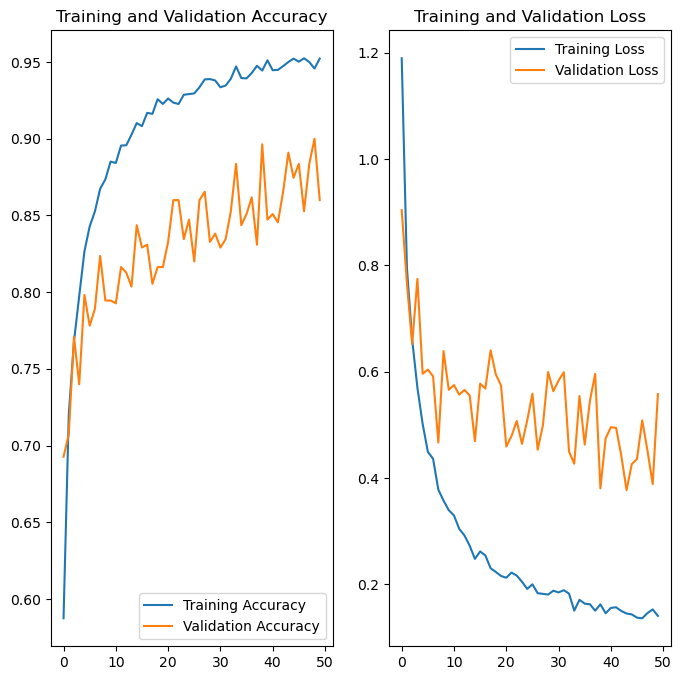

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: pyrite
1/1 [==============================] - 0s 351ms/step
predicted label: pyrite


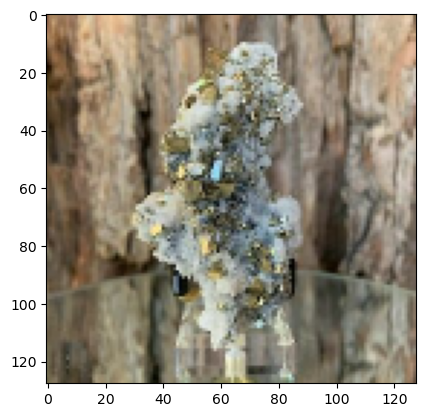

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 47ms/step


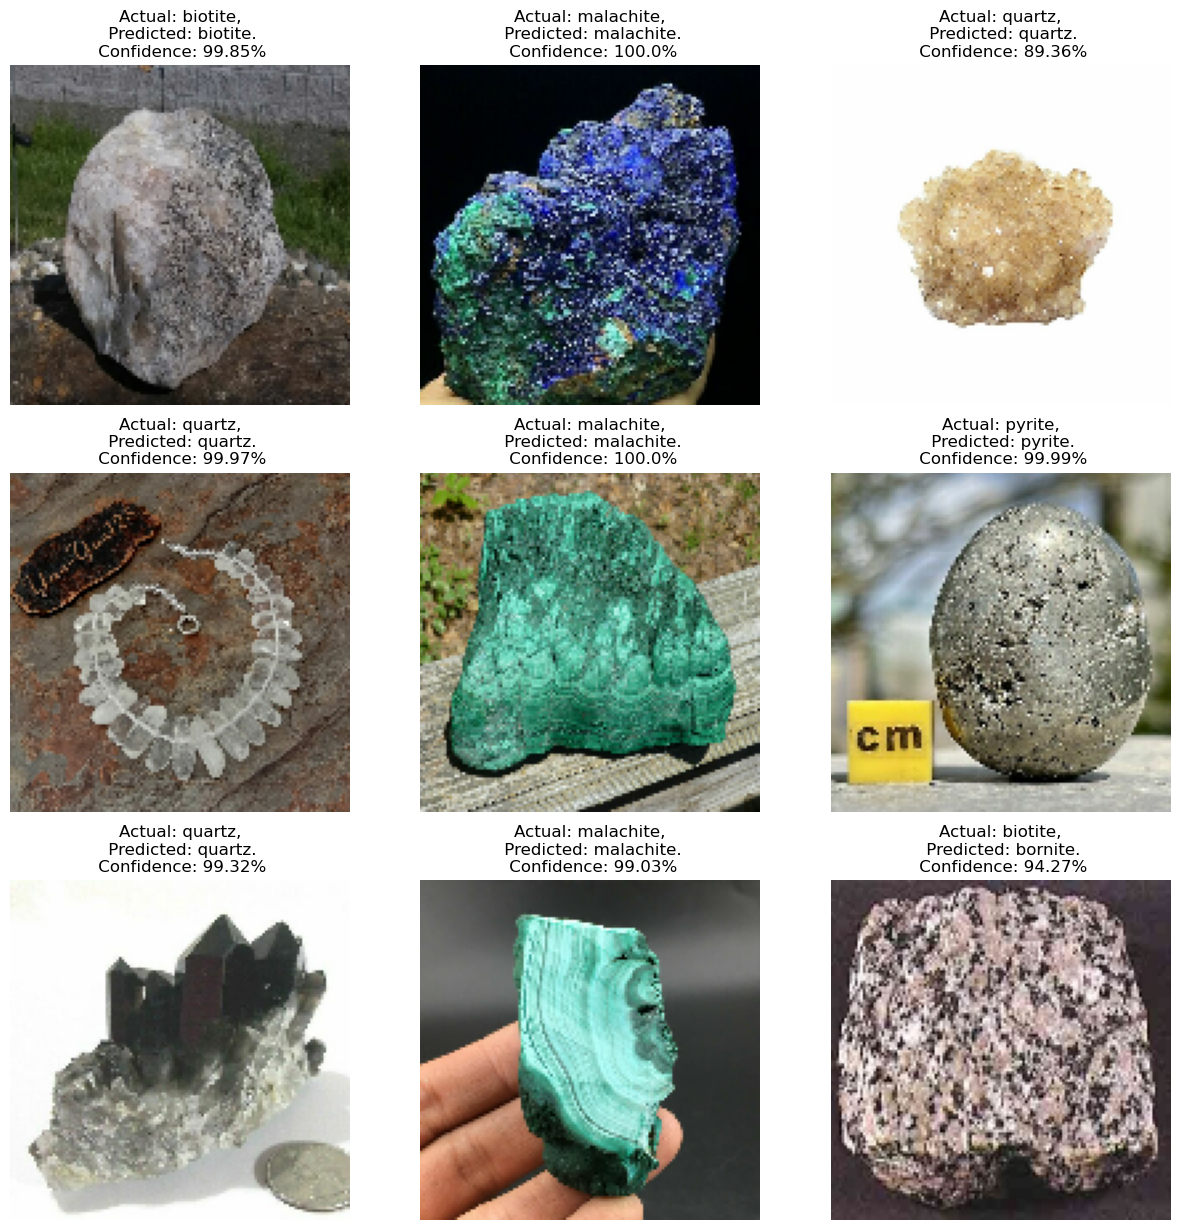

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [84]:
import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model_version="Minerals_1"
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/Minerals_1\assets


INFO:tensorflow:Assets written to: ../models/Minerals_1\assets


In [34]:
model.save("../Minerals_2.h5")

C:\Users\PC\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Loading the model and cheking it works.

In [2]:
import tensorflow as tf

# Replace 'your_model_path/model_name.h5' with the actual path to your model file
model_path = r'C:\Users\PC\Documents\Data Science\mineral-classification\models\Minerals_1'

# Load the model
model = tf.keras.models.load_model(model_path)

# Display the model summary to inspect the architecture
model.summary()




Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_8 (Dense)             (None, 64)                64128     
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 1757072 (6.70 MB)
Trainable params: 64583 (252.28 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [21]:
scores = model.evaluate(test_ds)


23/23 [==============================] - 53s 69ms/step - loss: 0.5715 - accuracy: 0.8432
